In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular

In [2]:
# 1. Carregar dados
# Carregar dataset
columns = [
    "duration",  # Duração da conexão em segundos
    "protocol_type",  # Tipo de protocolo utilizado (tcp, udp, icmp)
    "service",  # Serviço de destino (ex: http, ftp, telnet)
    "flag",  # Estado da conexão TCP (ex: SF - conexão finalizada sem erro)
    "src_bytes",  # Bytes enviados da origem para o destino
    "dst_bytes",  # Bytes recebidos pelo destino
    "land",  # 1 se origem e destino são iguais (ataque land), 0 caso contrário
    "wrong_fragment",  # Número de fragmentos incorretos
    "urgent",  # Número de pacotes urgentes
    "hot",  # Número de acessos a diretórios sensíveis do sistema
    "num_failed_logins",  # Número de tentativas de login falhas
    "logged_in",  # 1 se o login foi bem-sucedido, 0 caso contrário
    "num_compromised",  # Número de condições que comprometem a segurança do sistema
    "root_shell",  # 1 se um shell root foi obtido, 0 caso contrário
    "su_attempted",  # 1 se houve tentativa de usar `su` para privilégio, 0 caso contrário
    "num_root",  # Número de acessos como root
    "num_file_creations",  # Número de operações de criação de arquivos
    "num_shells",  # Número de shells abertos
    "num_access_files",  # Número de acessos a arquivos críticos do sistema
    "num_outbound_cmds",  # Número de comandos outbound em conexão FTP (sempre 0 no dataset)
    "is_host_login",  # 1 se login foi feito no host, 0 caso contrário
    "is_guest_login",  # 1 se login foi feito como convidado, 0 caso contrário
    "count",  # Número de conexões para o mesmo host nas últimas 2 segundos
    "srv_count",  # Número de conexões para o mesmo serviço nas últimas 2 segundos
    "serror_rate",  # Taxa de conexões com erro de sincronização (SYN)
    "srv_serror_rate",  # Taxa de conexões com erro de sincronização no mesmo serviço
    "rerror_rate",  # Taxa de conexões rejeitadas
    "srv_rerror_rate",  # Taxa de conexões rejeitadas no mesmo serviço
    "same_srv_rate",  # Taxa de conexões para o mesmo serviço
    "diff_srv_rate",  # Taxa de conexões para serviços diferentes
    "srv_diff_host_rate",  # Taxa de conexões para diferentes hosts no mesmo serviço
    "dst_host_count",  # Número de conexões para o mesmo destino
    "dst_host_srv_count",  # Número de conexões para o mesmo serviço no destino
    "dst_host_same_srv_rate",  # Taxa de conexões para o mesmo serviço no destino
    "dst_host_diff_srv_rate",  # Taxa de conexões para serviços diferentes no destino
    "dst_host_same_src_port_rate",  # Taxa de conexões para o mesmo destino usando a mesma porta de origem
    "dst_host_srv_diff_host_rate",  # Taxa de conexões para diferentes hosts no mesmo serviço no destino
    "dst_host_serror_rate",  # Taxa de conexões com erro de sincronização no destino
    "dst_host_srv_serror_rate",  # Taxa de conexões com erro de sincronização no mesmo serviço no destino
    "dst_host_rerror_rate",  # Taxa de conexões rejeitadas no destino
    "dst_host_srv_rerror_rate",  # Taxa de conexões rejeitadas no mesmo serviço no destino
    "label",  # Tipo de ataque ou "normal" se for tráfego legítimo
    "level",  # Gravidade do ataque (normalmente não usado)
]

train = pd.read_csv("../../data/raw/NSL-KDD/KDDTrain+.txt", names=columns)
test = pd.read_csv("../../data/raw/NSL-KDD/KDDTest+.txt", names=columns)

In [3]:
# 2. Pré-processamento
for df in [train, test]:
    df.drop(["difficulty"], axis=1, errors="ignore", inplace=True)
    df["label"] = df["label"].apply(
        lambda x: 0 if x == "normal" else 1
    )  # Binário: normal ou ataque

categorical = ["protocol_type", "service", "flag"]
train = pd.get_dummies(train, columns=categorical)
test = pd.get_dummies(test, columns=categorical)

# Ajustar colunas do test
for col in set(train.columns) - set(test.columns):
    test[col] = 0
test = test[train.columns]

In [4]:
# 3. Separar features e labels
X_train = train.drop("label", axis=1)
y_train = train["label"]
X_test = test.drop("label", axis=1)
y_test = test["label"]

In [11]:
from sklearn.model_selection import GridSearchCV

# 4. Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Parâmetros para busca
param_grid = {
    "num_leaves": [31, 50, 70],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [100, 300, 500],
    "scale_pos_weight": [1, 10, 20],
}

lgbm = LGBMClassifier(random_state=42)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    verbose=3,
    n_jobs=-1,
)

grid.fit(X_train_split, y_train_split)

print("Melhores parâmetros encontrados:")
print(grid.best_params_)

best_model = grid.best_estimator_

# Avaliação no conjunto de validação
y_pred = best_model.predict(X_val)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nMatriz de Confusão:")
print(confusion_matrix(y_val, y_pred))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Number of positive: 46904, number of negative: 53874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3320
[LightGBM] [Info] Number of data points in the train set: 100778, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465419 -> initscore=-0.138545
[LightGBM] [Info] Start training from score -0.138545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

c:\Users\mathe\Documents\Estudos\TCC-UDESC\xai-in-ids\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report (Conjunto de Teste):
              precision    recall  f1-score   support

           0       0.72      0.84      0.77      9711
           1       0.86      0.75      0.80     12833

    accuracy                           0.79     22544
   macro avg       0.79      0.80      0.79     22544
weighted avg       0.80      0.79      0.79     22544


Matriz de Confusão (Conjunto de Teste):
[[8130 1581]
 [3154 9679]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.72      0.84      0.77      9711
           1       0.86      0.75      0.80     12833

    accuracy                           0.79     22544
   macro avg       0.79      0.80      0.79     22544
weighted avg       0.80      0.79      0.79     22544



c:\Users\mathe\Documents\Estudos\TCC-UDESC\xai-in-ids\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


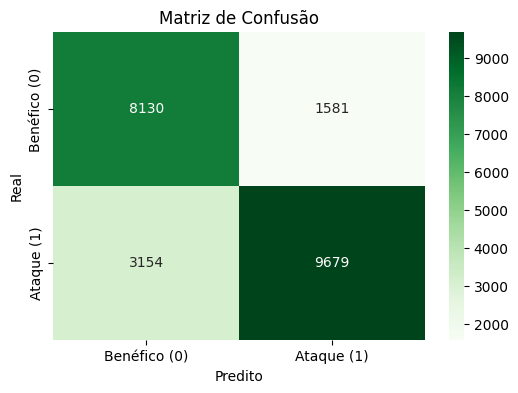

In [12]:
# Avaliação no conjunto de teste
y_test_pred = best_model.predict(X_test_scaled)

print("\nClassification Report (Conjunto de Teste):")
print(classification_report(y_test, y_test_pred))

print("\nMatriz de Confusão (Conjunto de Teste):")
print(confusion_matrix(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

print("Relatório de Classificação:\n", classification_report(y_test, y_test_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Benéfico (0)", "Ataque (1)"],
    yticklabels=["Benéfico (0)", "Ataque (1)"],
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

c:\Users\mathe\Documents\Estudos\TCC-UDESC\xai-in-ids\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


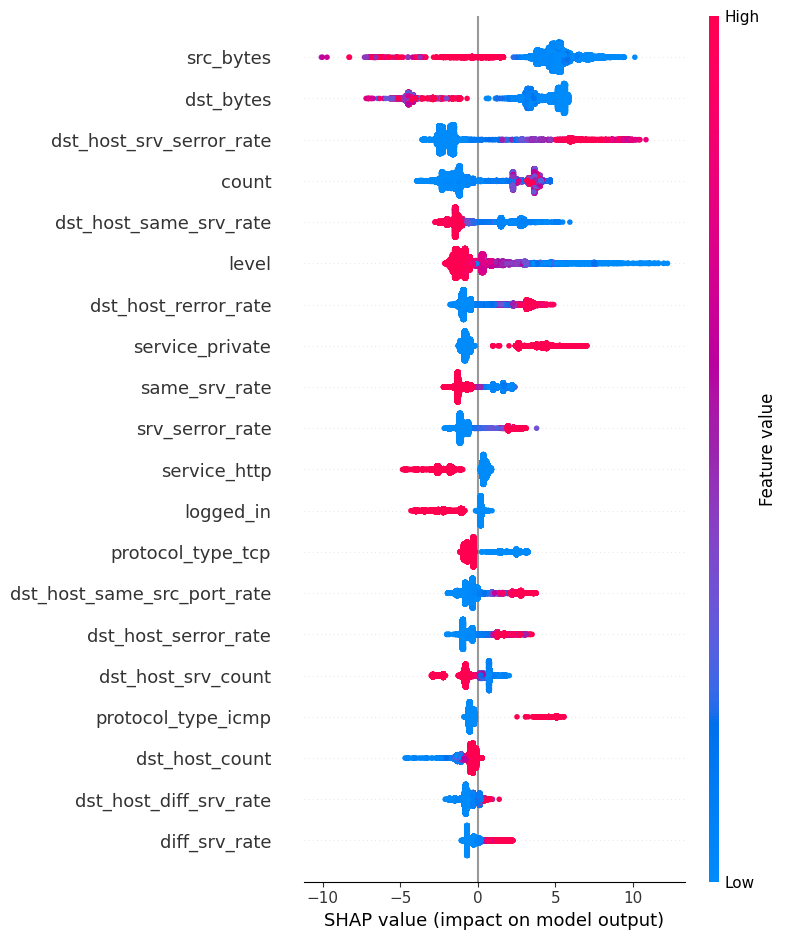

In [13]:
# Explicação com SHAP
feature_names = X_train.columns.tolist()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

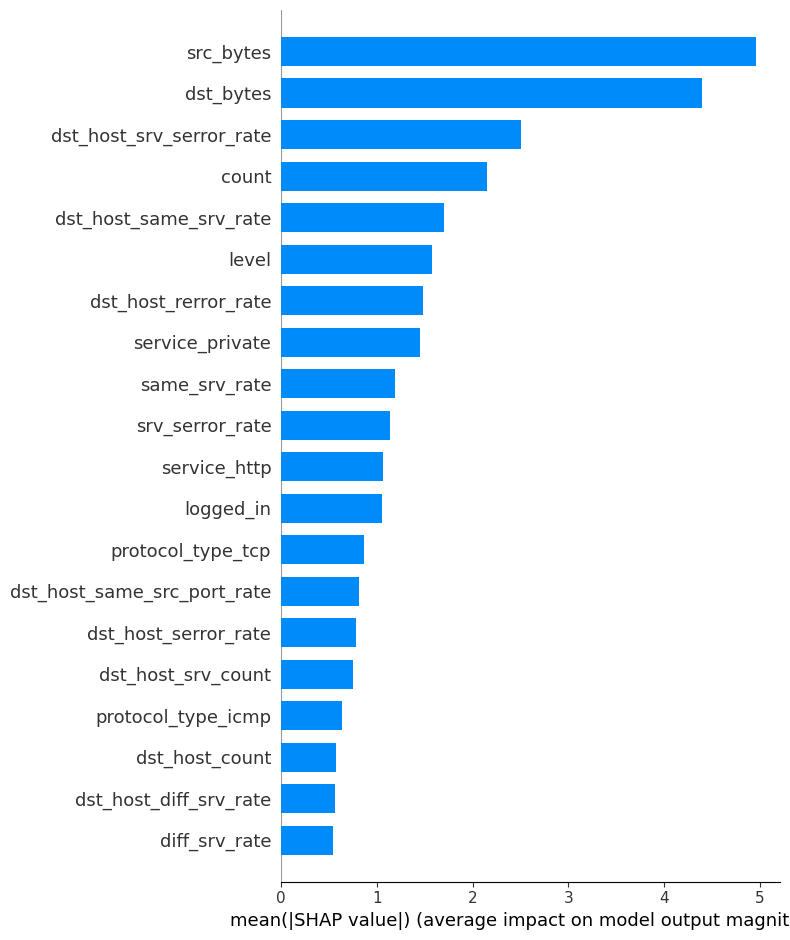

In [17]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=feature_names)

In [14]:
# Explicação com LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=train.drop("label", axis=1).columns.tolist(),
    class_names=["normal", "attack"],
    mode="classification",
)

instance = X_test_scaled[0]
exp = explainer_lime.explain_instance(instance, best_model.predict_proba, num_features=5)
exp.save_to_file("lime_explanation_lightgbm_nsl_kdd_instance_0.html")

c:\Users\mathe\Documents\Estudos\TCC-UDESC\xai-in-ids\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
